# Coursera Capstone Report

## Introduction

**Problem Description**: Many young families in Australia are struggling to find affordable housing. Inspired by this issue, I was drawn to collect past sales data from real estate websites, and combine this with FourSquare location data to build a simple predictive model that estimates a fair market value for a given property currently on the market, based upon its similarity to past sales and its location (+ external factors such as time of sale). For now, we focus on a region of particular personal interest: Canberra and the surrounds.


## Data

1. **Real Estate Data**: Real estate data has been scraped from https://www.auhouseprices.com/act/, which to the best of my knowledge, does not forbid web scraping. We collect the following data points from listing directories:
    * Recent sales
    * Suburb Names
    * Sold Prices
    * Sold Date
    * Property Type
    * Number of beds
    * Number of baths
    * Number of car spaces
    * Location (both latitude and longitude)


2. **Suburb Data**: The latitude and longitude of each suburb name, (itself extracted from the above data source), was obtained using the OpenCage API.


3. **Venue Data**: Per previous work, location data can be served for free (with limitations) via the FourSquare API. We will use this to collect information about venues near previously-sold and for-sale houses. 


4. **Mapping Data:** Maps are generated interactively using Folium, with suburb boundary data obtained from https://data.gov.au/dataset/ds-dga-0257a9da-b558-4d86-a987-535c775cf8d8/details?q=act%20suburb

## Methodology

The methodology section is divided naturally into several parts, which form the basis of the results section. We gloss over data preparation and sanitisation process, which primarily involved coercing datatypes and merging data from different sources.

1. **Data preparation and sanitisation**
2. **Exploratory data analysis and visualisation**
3. **Feature engineering**
4. **Model development**
5. **Model validation**


#### Exploratory Data Analysis and Visualisation ####

In this section, we ask the following simple questions of the data, with an eye toward discerning key features and assessing data accuracy. In this stage, we also remove anomolous data points, including a property that allegedly sold for over 1 billion dollars and several that sold for less than 10,000.

1. How many suburbs have we collected data on?
2. Over what time period do we have sales data for?
3. What is the min/max/mean/median sale price per suburb?
4. What is the min/max/mean/median number of beds/baths/cars?
5. How many sales per suburb?
6. Any weird bits of data in any column? NaNs?
7. Do we have enough data for each suburb to make reasonable statistical inferences?

#### Feature Engineering ####

Following from the insights of the previous section, we append suburb-level (as opposed to property-level) features to the dataset. These features include the latitude and longitude of the suburbs served by the OpenCage API, and from that, the venues within two kilometres of the suburb coordinates as served by FourSquare. The idea here is to supplement the real-estate data with suburb-level detail, which may provide greater insights into the considerations which drive property prices in the ACT. At this stage, we also limit our consideration to properties sold within the last 5 years, to mitigate the confounding effect of time variability in our dataset.


#### Model Development ####

Given that we are trying to predict a continuous variable from a collection of (allegedly independent) categorical and continuous variables, we opted to develop a multiple linear regression (MLR) model. In order to do this, the following steps were taken:

1. One-hot encoding of categorical variables
2. Train/test 80/20 split
3. Regularization
4. Backward elimination (see Model Validation)

Followed by actual model development. We develop a series of models under different conditions, firstly without regularization or backward elimination, then with regularization and backward elimination on the model prior to feature engineering, then with regularization and backward elimination on the engineered model. We use the scikit-learn linear regression library in the first instance, and both scikit-learn and the ordinary-least-squares capability within the statsmodel API library for the two latter models that employ backward elimination.

#### Model Validation ####

Incorporating suburb-level information into our model requires the addition of a significant number of variables. This introduces several potential issues, including for example an increased risk of overfitting or variable collinearity. For this reason, we employ backward elimination, which involves removing independent variables that do not have a significant effect upon the dependent variable. Following this, we use the summary statistics provided by the statsmodel API to get an idea of whether the resulting model is appropriate (i.e. not over-fit, etc). Specifically, we refer to the Omnibus score, the prod(Omnibus) score, the Durbin-Watson statistic, and the Jarque-Bera and prob(Jarque-Bera) scores.

## Results & Discussion

The results section is combined with the discussion section, and divided into two parts, being (a) General Observations, and (b) Model Results. 



### General Observations ###

We note from a general inspection of the data, that:

1. Consistent with expectations, it looks like houses sold near the centre of the city (i.e. Yarralumla, Deakin, O'Connor, Ainslie, Campbell) go for the highest prices. (Figure 1, Figure 2)
2. Median house prices are invariably trending upwards over the period 1970-2021, regardless of location. (Figure 3)
3. The first few years of data for a given suburb typically have a 'spike' (Figure 3). We determine this to be an artefact of insufficient data. (Figure 4)


##### Figure 1 #####
House price distribution in Canberra, using data from 1970-2021, grouped by suburb. Suburbs selected from those with greatest number of recent sales.

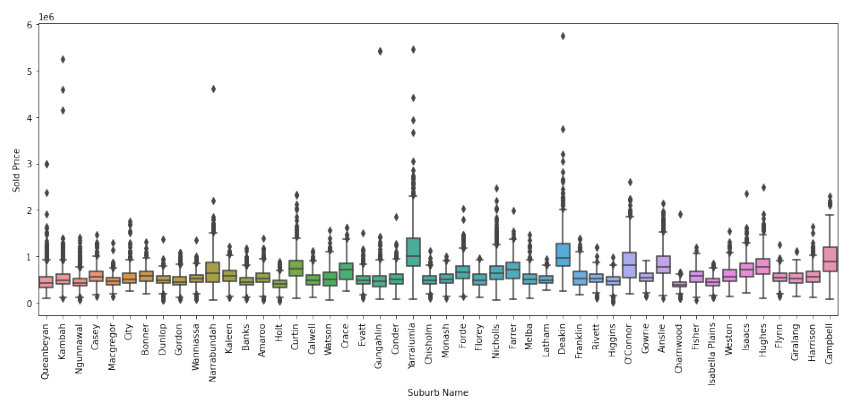

In [19]:
import matplotlib.pyplot as plt
%matplotlib inline
img = plt.imread("images/house_prices_canberra.png")
plt.figure(figsize=(15,8))
plt.imshow(img)
plt.axis("off");

hide_toggle()

##### Figure 2 #####
Map of the ACT with suburb boundaries; suburbs coloured by median house price over the period 1970-2021. There is a clear relationship between the median house price and the proximity to the centre of Canberra. This is reflected also in the median price distributions of **Figure 1**. Note that we can cast this relationship as the property longitude versus median house price.

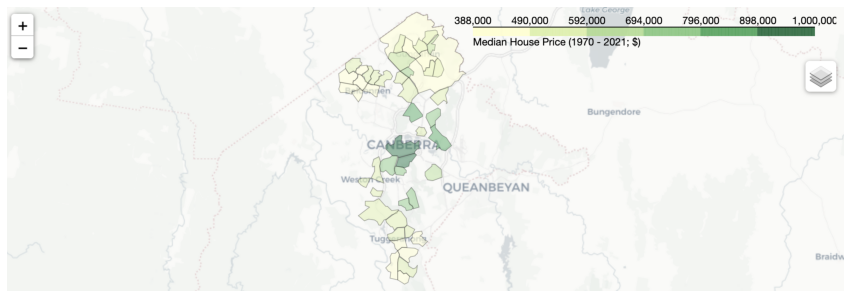

In [22]:
%matplotlib inline
img = plt.imread("images/map_screenshot.png")
plt.figure(figsize=(15,8))
plt.imshow(img)
plt.axis("off");

hide_toggle()

##### Figure 3 #####

Plot of the median house price over the period 1970-2021, grouped by suburb. Selecting some of the more affluent neighbourhoods, as well as some of the less-affluent neighbourhoods, from **Figure 1**, it can be seen that median house prices for both trends upwards over time over the period 1970-2021. It is of some interest that the degree of variability in the affluent neighbourhoods is greater than that of the less-affluent neighbourhoods.

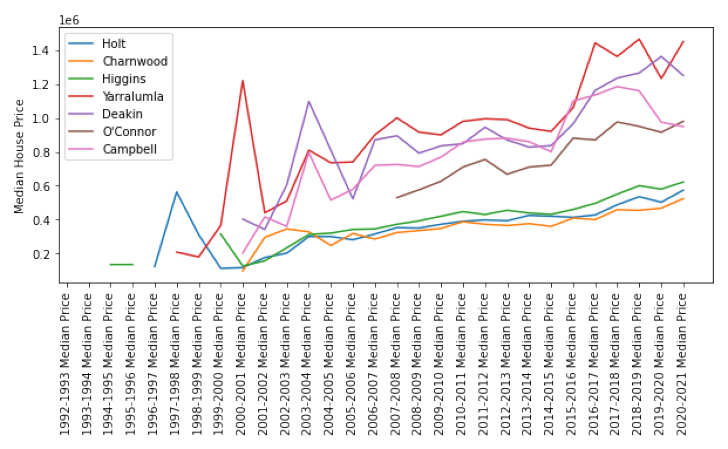

In [23]:
%matplotlib inline
img = plt.imread("images/median_house_price_over_time_select_suburbs.png")
plt.figure(figsize=(15,8))
plt.imshow(img)
plt.axis("off");

hide_toggle()

##### Figure 4 #####
Plot of median house prices for the suburb Yarralumla over the period 1970-2021 (line), overlaid with plot of number of sales (bar chart). Selecting one of the most affluent neighbourhoods as an example, we find that the 'spike' in median house prices seen for most suburbs in **Figure 3** is clearly an artefact of insufficient data.

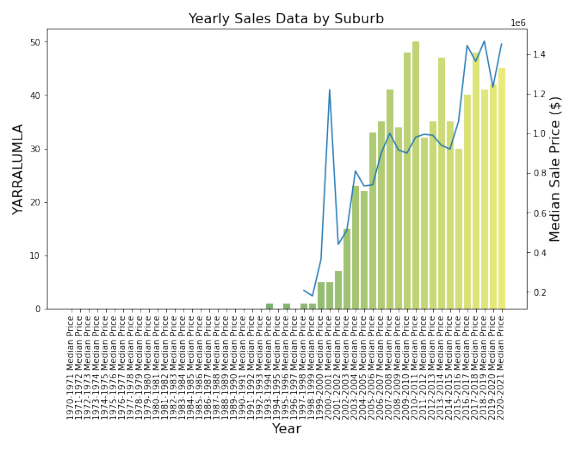

In [27]:
%matplotlib inline
img = plt.imread("images/insufficient_data_median_prices.png")
plt.figure(figsize=(15,8))
plt.imshow(img)
plt.axis("off");

hide_toggle()

### Model Results ###

We trained three MLR models on different subsets of the complete dataset, or under different conditions. All models were trained and tested using a 80/20 split, on data from 2016-2021.
1. Model 1. Full feature set, no regularization or backward elimination
2. Model 2. Feature set prior to addition of suburb profile, with regularization and backward elimination
3. Model 3. Full feature set, with regularization and backward elimination

The results are summarised below:

| Model | R^2  | Omnibus | Durbin-Watson | Cond. Number |
| :---: |:----:|:-------:|:-------------:|:------------:|
| 1     |0.733 |   N/A   |      N/A      |     N/A      |
| 2     |0.445 | 2069.87 |     2.029     |     2.88     |
| 3     |0.729 | 2404.62 |     2.009     |   3.21e+16   |

Of these, the R^2 value is uncentered; the Omnibus score is a test of the kurtosis and skew of the residuals from OLS fitting - ideally, we would like to see a value close to 1, as this would indicate normalcy; the Durbin-Watson score tests for homoscedasticity, and we would like to see a value between 1 and 2, where 2 indicates no autocorrelation; the Condition Number measures the sensitivity of the model output compared to its inputs, and we hope for a small (<30) number.

**Model 1** has the highest R^2 value - however, it should be clear that the addition of ~200 independent variables does not come without consequence. We evaluate this model purely as a starting point, though we should be aware that it is likely suffering from collinearity or overfitting.

**Model 2** is a model built upon only the scraped real-estate data (number of beds, baths, car spaces, location, and property type). It has the lowest R^2 value, and an undesirably-large Omnibus score. The former could mean any of several things, but the very high Omnibus score likely means that the model suffers from significant kurtosis or skew, and might be better modelled using a nonlinear approach. However, the Durbin-Watson statistic and Condition Number are reasonable, suggesting the independent variables are not collinear or autocorrelated.

Interestingly, after backward elimination, the variables for latitude, number of car spaces, and all binary property types except for "House" are removed. Intuitively, this makes some sense, as we can see from **Figure 2** above that median house prices vary along the line of longitude, but vary little about lines of latitude. Further, one might deduce from this model that homeowners are less concerned with the number of car spaces as they are with the availability of beds and bathrooms (in turn, this might lead one to speculate about the relationship between the planned, 'suburb-centric' development pattern of Canberra, the relative need for vehicles over bicycles to travel between shopping centres/venues of interest, and the large tertiary student / public servant profile of Canberra). Finally, the model seems to suggest that a main factor in house prices in Canberra is simply whether the property is a house, or is not a house (i.e. is a unit, or a townhouse), which is both interesting and seemingly intuitive.

**Model 3** The R^2 value rivals that of Model 1; however, both the Omnibus score and the Condition Number are unacceptably large, probably reflecting issues with collinearity or autocorrelation. It is possible that venue data is by construction collinear, because venues will cluster together in shopping centres. From the perspective of the model, then, one could for example say that the existence of a supermarket venue implies the existence of a takeaway venue, because they are so often found together in the radius of our search. The end result is probably that the resulting model is over-fit - this might be able to be remedied with some validation beyond the backward elimination, by employing a non-linear model, or by selecting the venues of interest with greater care.

## Conclusion

We developed a model which can predict house prices in the Canberra region with an R^2 = 0.45, and requires only information about the number of recent sales in the area, the longitude of the house, the numbers of beds and baths, and a binary indication of the property type (i.e. house or not-house). This model is hardly predictive, and likely should be approached using a non-linear model; however, it leads to intuitive insights into the various factors which drive property prices in the ACT, and which factors are not significant, such as the number of car spaces, or the property latitude.

We also used venue data from FourSquare (per assignment requirements) to determine if we could improve our model predictions by incorporating information about the venues available to each suburb. We were limited in our ability to build property-specific profiles by the number of API calls we were allowed to make. Including suburb venue data increased our R^2 value to 0.73 after regularization and backward elimination, though this model has significant issues which suggest that either the underlying model construction should be revisited, or that our feature selection could be more rigorous.

If we were to suggest any model from the above, we would recommend Model 2, on the basis of the intuitive understanding that it can 

In [20]:
from IPython.display import HTML
import random

def hide_toggle(for_next=False):
    this_cell = """$('div.cell.code_cell.rendered.selected')"""
    next_cell = this_cell + '.next()'

    toggle_text = 'Toggle show/hide'  # text shown on toggle link
    target_cell = this_cell  # target cell to control with toggle
    js_hide_current = ''  # bit of JS to permanently hide code in current cell (only when toggling next cell)

    if for_next:
        target_cell = next_cell
        toggle_text += ' next cell'
        js_hide_current = this_cell + '.find("div.input").hide();'

    js_f_name = 'code_toggle_{}'.format(str(random.randint(1,2**64)))

    html = """
        <script>
            function {f_name}() {{
                {cell_selector}.find('div.input').toggle();
            }}

            {js_hide_current}
        </script>

        <a href="javascript:{f_name}()">{toggle_text}</a>
    """.format(
        f_name=js_f_name,
        cell_selector=target_cell,
        js_hide_current=js_hide_current, 
        toggle_text=toggle_text
    )

    return HTML(html)

hide_toggle()